### <b> Predicting House Price </b>

### <b>Importing the Libraries</b>

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set(style='darkgrid', font_scale=1.5)
pd.set_option('display.max.columns', None)
%matplotlib inline


import warnings

warnings.filterwarnings('ignore')

from scipy import stats
from scipy.stats import skew, boxcox_normmax
from scipy.special import boxcox1p


from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.preprocessing import RobustScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.impute import SimpleImputer



#### <b> Data Loading</b>

In [2]:
# Path to the directory containing the dataset
dataset_dir = '../Dataset'

try:
    # Listing the content of the directory
    files = os.listdir(dataset_dir)

    # Filtering out non-CSV files
    csv_files = [file for file in files if file.endswith('.csv')]

    train_data = None
    test_data = None

    # Looping through the files
    if csv_files:  # Check if csv_files is not empty
        for csv_file in csv_files:
            csv_path = os.path.join(dataset_dir, csv_file)

            if 'train' in csv_file.lower():
                try:
                    train_data = pd.read_csv(csv_path)
                except Exception as e:
                    print(f"Error reading train CSV: {e}")
            elif 'test' in csv_file.lower():
                try:
                    test_data = pd.read_csv(csv_path)
                except Exception as e:
                    print(f"Error reading test CSV: {e}")
    else:
        print("No CSV files found in the specified directory.")

except FileNotFoundError:
    print(f"Directory '{dataset_dir}' not found.")
except Exception as ex:
    print(f"An error occurred: {ex}")


In [4]:
#displaying the first 5 rows
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


#### <b> Data Exploration </b>

1. Checking the dimensions of the Datasets

In [5]:
print('Train Dataset has ', train_data.shape[0], 'Records/Row and ', train_data.shape[1], 'features/columns', '\n')
print('Test Dataset has ', test_data.shape[0], 'Records/Row and ', test_data.shape[1], 'features/columns')

Train Dataset has  1460 Records/Row and  81 features/columns 

Test Dataset has  1459 Records/Row and  80 features/columns


2. General Information of Train Data

In [6]:
train_data.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 81 entries, Id to SalePrice
dtypes: float64(3), int64(35), object(43)
memory usage: 924.0+ KB


Observations:
1. There is a total of 1460 record entries and 81 column entries
2. The common data-types includes float64, int64 and object
3. Out of the 81 columns: 
   <ul>
      <li> 38 columns are numerical and </li>
      <li> 43 columns are categorical </li>
   </ul>

3. Overall Statistics on Catergorical Data

In [8]:
train_data.describe(include='object')

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,588,1460,1460,1460,1423,1423,1422,1423,1422,1460,1460,1460,1459,1460,1460,770,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,8,5,8,6,8,15,16,3,4,5,6,4,4,4,6,6,6,5,2,5,4,7,5,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,1445,1220,726,1141,1434,515,504,445,906,1282,647,649,1311,953,430,1256,1428,741,1365,1334,735,1360,380,870,605,1311,1326,1340,3,157,49,1267,1198


Observations:
1. Most of the categorical fetaures are not having high cardinality
2. Features like Neihborhood, Exterior1st, Exterior2nd are having a littile bit of high cardinality

4. Overall Statistical Analysis on Numerical Features

In [9]:
train_data.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


Observations
1. Numerical Features like LotArea, GrLivArea,BsmtUnfSF	, TotalBsmtSF, MiscVal, and even target feature SalePrice are having very high standard deviation values which can lead to overfitting and affect the model
2.  They will need to be transformed to reduce the deviations

### <b> Data Preprocessing Part 1 </b>

1. Displaying a Random Sample of the Data

In [10]:
train_data.sample(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
327,328,20,RL,80.0,11600,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,175.0,TA,TA,CBlock,TA,TA,No,Rec,565,Unf,0,818,1383,GasA,TA,Y,SBrkr,1383,0,0,1383,0,0,1,1,3,1,TA,7,Typ,0,NaN,Attchd,1960.0,RFn,1,292,TA,TA,Y,0,45,0,0,0,0,NaN,NaN,NaN,0,4,2006,WD,Normal,145250
1404,1405,50,RL,60.0,10410,Pave,Grvl,Reg,Lvl,AllPub,Corner,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,3,4,1915,1950,Gable,CompShg,Wd Sdng,Wd Sdng,NaN,0.0,TA,TA,PConc,TA,TA,No,Unf,0,Unf,0,672,672,GasA,TA,Y,SBrkr,694,520,0,1214,0,0,1,0,3,1,TA,6,Typ,0,NaN,Detchd,1998.0,Unf,3,936,TA,TA,Y,216,0,160,0,0,0,NaN,MnPrv,NaN,0,1,2006,WD,Family,105000
278,279,20,RL,107.0,14450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,9,5,2006,2007,Gable,CompShg,CemntBd,CmentBd,BrkFace,315.0,Ex,TA,PConc,Ex,TA,Gd,Unf,0,Unf,0,2121,2121,GasA,Ex,Y,SBrkr,2121,0,0,2121,0,0,2,1,3,1,Ex,8,Typ,1,Ex,Attchd,2007.0,Fin,3,732,TA,TA,Y,124,98,0,0,142,0,NaN,NaN,NaN,0,5,2007,New,Partial,415298


Observations:
1. The Id feature represent a unique number mapped to different house recorded in the dataset
2. The feature isn't relevent so we can easily drop it but first we will need to store it

2. Dropping the Id feature

In [11]:
#remove the Id feature from bothb train and test data
test_id = test_data['Id'] # saving the Id feature

#dropping the Id feature
train_data.drop('Id', axis=1, inplace=True)
test_data.drop('Id', axis=1, inplace=True)


3. Checking for Missing Values greater than or equal to 50%

In [12]:
null_df = round(
    train_data.isnull().sum()/ len(train_data) * 100
,2).sort_values().to_frame().rename(columns={
    0:'Train Data % of Missing Values'
})

null_df['Test Data % of Missing Values'] = round(
    test_data.isnull().sum()/ len(train_data) * 100
,2)

In [13]:
null_df[
    (null_df['Train Data % of Missing Values'] > 45) | (null_df['Test Data % of Missing Values']>45)
]

,Train Data % of Missing Values,Test Data % of Missing Values
FireplaceQu,47.26,50.00
MasVnrType,59.73,61.23
Fence,80.75,80.07
Alley,93.77,92.60
MiscFeature,96.30,96.44
PoolQC,99.52,99.73


Observations:
1. Features like PoolQC, MiscFeature,MasVnrType, Alley and Fence satisfied both condition and as such are having a very large number of missing values
2. The FireplaceQu satisfied only only of the condition but due to the operator it was included
<ul>
 
<li> Data Imputation in thses features with large percenateg of missing values can lead to bias in the dataset</li>

<li> We will simply drop thses features </li>

</ul>

4. Dropping Features with more than 50% of Missing Values

In [14]:
#selecting the columns of interest
columns = ['PoolQC', 'MasVnrType', 'MiscFeature', 'Alley' ,'Fence', 'FireplaceQu']

#eliminating the columns of interest
train_data.drop(columns=columns, inplace=True)
test_data.drop(columns=columns, inplace=True)

5. Combining the Train & Test Dataset

In [15]:
#getting the target
target = train_data[['SalePrice']].reset_index(drop=True)

#removing the SalePrice from the train data
train_data.drop(columns=['SalePrice'], inplace=True)

#combining the two datasets
df = pd.concat(
    [train_data, test_data]
).reset_index(drop=True)

In [16]:
#checking the dimensions
df.shape

(2919, 73)

6. Checking for Missing Values again

In [17]:
null_df = df.isnull().sum()[df.isnull().sum()>0].sort_values().to_frame().rename(columns={0:"Total Missing values"})
null_df["% of Missing Values"] = round(null_df["Total Missing values"]/len(df)*100,2)
null_df["Feature Data Type"] = df[null_df.index.tolist()].dtypes

In [18]:
null_df

,Total Missing values,% of Missing Values,Feature Data Type
BsmtUnfSF,1,0.03,float64
GarageArea,1,0.03,float64
GarageCars,1,0.03,float64
KitchenQual,1,0.03,object
Electrical,1,0.03,object
TotalBsmtSF,1,0.03,float64
BsmtFinSF2,1,0.03,float64
BsmtFinSF1,1,0.03,float64
SaleType,1,0.03,object
Exterior1st,1,0.03,object


Observations:
1. There is a total of 28 features still having missing values 
2. We will fill thses values separately

7. Filling Missing Values in Garage and Basement

In [19]:
#filling the categorical features
for col in ['GarageFinish', 'GarageQual', 'GarageCond', 'GarageType']:
    df[col] = df[col].fillna('None')


for col in ['BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'BsmtExposure', 'BsmtCond']:
    df[col] = df[col].fillna('None')



#filling the numerical features
for col in ['GarageArea', 'GarageCars', 'GarageYrBlt']:
    df[col]= df[col].fillna(0)

for col in ['BsmtHalfBath', 'BsmtFullBath']:
    df[col]= df[col].fillna(0)


8. Filling Missing Values in Categorical Columns

In [20]:
cat_cols = ['Utilities', 'Exterior1st', 'Exterior2nd', 'Electrical',
            'KitchenQual', 'Functional', 'SaleType']

#instance of the imputer

#filling with the mode
imputer = SimpleImputer(strategy='most_frequent')
df[cat_cols]= imputer.fit_transform(df[cat_cols])

9. Filling Missing Values in the rest features

In [21]:
#filling with meadian values
df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
df['BsmtFinSF1']= df.groupby('BsmtFinType1')['BsmtFinSF1'].transform(lambda x: x.fillna(x.median()))
df['BsmtFinSF2']= df.groupby('BsmtFinType2')['BsmtFinSF2'].transform(lambda x: x.fillna(x.median()))
df['BsmtUnfSF']= df['BsmtUnfSF'].fillna(df['BsmtUnfSF'].median())
df['MasVnrArea'] = df['MasVnrArea'].fillna(df['MasVnrArea'].median())

#filling with sum
df['TotalBsmtSF'] = df['BsmtFinSF1'] + df['BsmtFinSF2']


In [22]:
#filling with mode
df['MSZoning']= df.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

10. Validating the Data

In [23]:
print('Numb er of Missing Values:', df.isnull().sum().sum())

Numb er of Missing Values: 0


11. Splitting the Data back to Train and Test Dataframes sets

In [24]:
train_data = pd.concat(
    [df.iloc[:len(target['SalePrice']),:], target], axis=1
)

test_data = df.iloc[len(target['SalePrice']):, :]

In [25]:
print("Dimension of train data is:",train_data.shape)
print("Dimension of test data is:",test_data.shape)

Dimension of train data is: (1460, 74)
Dimension of test data is: (1459, 73)


### <b> Exploratory Data Analysis </b>

1. Analyzing the Target Feature

In [26]:
train_data['SalePrice'].describe().to_frame()

,SalePrice
count,1460.000000
mean,180921.195890
std,79442.502883
min,34900.000000
25%,129975.000000
50%,163000.000000
75%,214000.000000
max,755000.000000


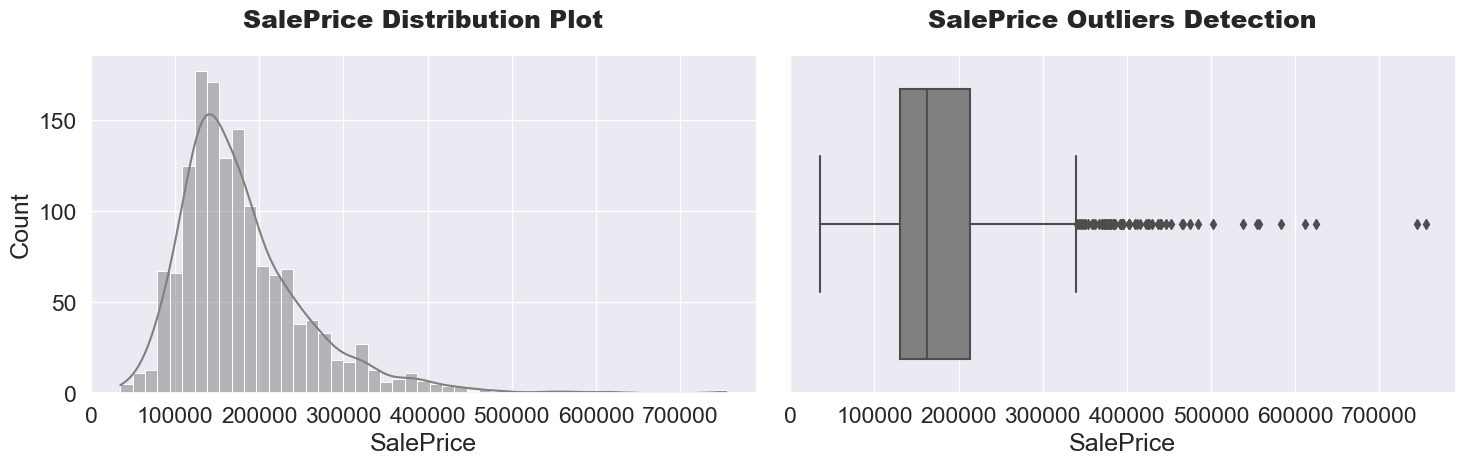

In [27]:
#visualzing the data

#increasing the figure size
plt.figure(figsize=(15,5))

#subplot 1
plt.subplot(1,2,1)
sns.histplot(
    train_data['SalePrice'], color='#808080', kde=True
)
plt.title("SalePrice Distribution Plot",fontweight="black",pad=20,size=18)

#subplot 2
plt.subplot(1,2,2)
sns.boxplot(
    x=train_data['SalePrice'], color='#808080'
)
plt.title("SalePrice Outliers Detection",fontweight="black",pad=20,size=18)

plt.tight_layout()
plt.show()

Observations:
1. The SalePrice is right skewed indicating the presence of positive outliers
2. The Target Feature doesn't follow a normal distribution due to it skewness it will be transformed to acheive a Normal Distribution before performing regression

2. Visualizing the Transform on feature 'SalePrice'

Text(0.5, 1.0, 'SalePrice Distribution Plot with Normal Transformation')

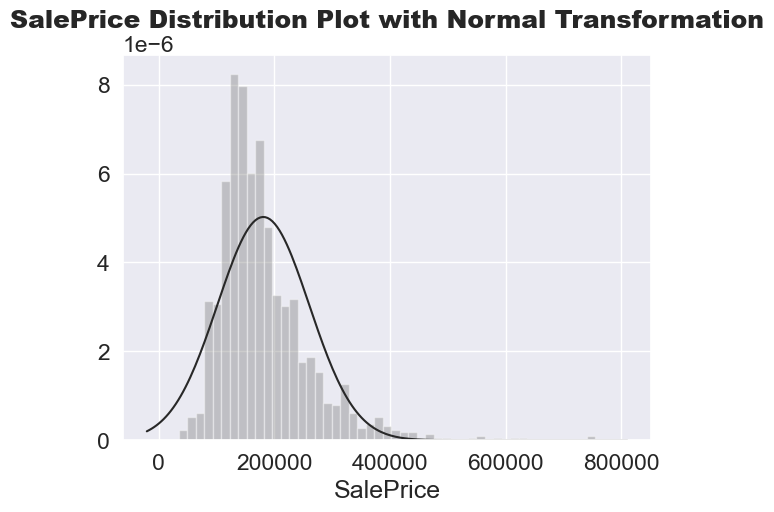

In [28]:
#increasing the figure size
plt.figure(figsize=(15,5))

#subplot 1
plt.subplot(1,2,1)
sns.distplot(
    train_data['SalePrice'], color='#808080', kde=False, fit=stats.norm
)
plt.title("SalePrice Distribution Plot with Normal Transformation",fontweight="black",pad=20,size=18)

After applying the transformation techniques the Log Normal Transformation has also done a good job to achieve a normal distribution

3. Visualizing Distribution of Continous Numerical Features.

In [64]:
num_cols = train_data.select_dtypes(include=['int64', 'float64'])

In [154]:
pd.DataFrame({
    'Features': [col for col in num_cols],
    'Number of Unique Values': [train_data[col].nunique() for col in num_cols.columns],
    'Continuous Values': [1 if train_data[col].nunique()> 20 else 0  for col in num_cols.columns],
    'Discrete Values': [1 if train_data[col].nunique()< 20 else 0  for col in num_cols.columns]
})

,Features,Number of Unique Values,Continuous Values,Discrete Values
0,MSSubClass,15,0,1
1,LotFrontage,112,1,0
2,LotArea,1073,1,0
3,OverallQual,10,0,1
4,OverallCond,9,0,1
5,YearBuilt,112,1,0
6,YearRemodAdd,61,1,0
7,MasVnrArea,327,1,0
8,BsmtFinSF1,637,1,0
9,BsmtFinSF2,144,1,0


Continous Feature --> 
[LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,
<br>
1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageArea,WoodDeckSF,
<br>
OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal]


Discrete Features --> ["MSSubClass","OverallQual","OverallCond","BsmtFullBath","BsmtHalfBath","FullBath","HalfBath","BedroomAbvGr",
            "KitchenAbvGr","TotRmsAbvGrd","Fireplaces","GarageCars","MoSold", 'YrSold']

In [175]:
#selecting contnuous features
con_cols = ["LotFrontage","LotArea","MasVnrArea","BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","TotalBsmtSF",
            "1stFlrSF","2ndFlrSF","LowQualFinSF","GrLivArea","GarageArea","WoodDeckSF","OpenPorchSF",
            "EnclosedPorch","3SsnPorch","ScreenPorch","PoolArea","MiscVal"]

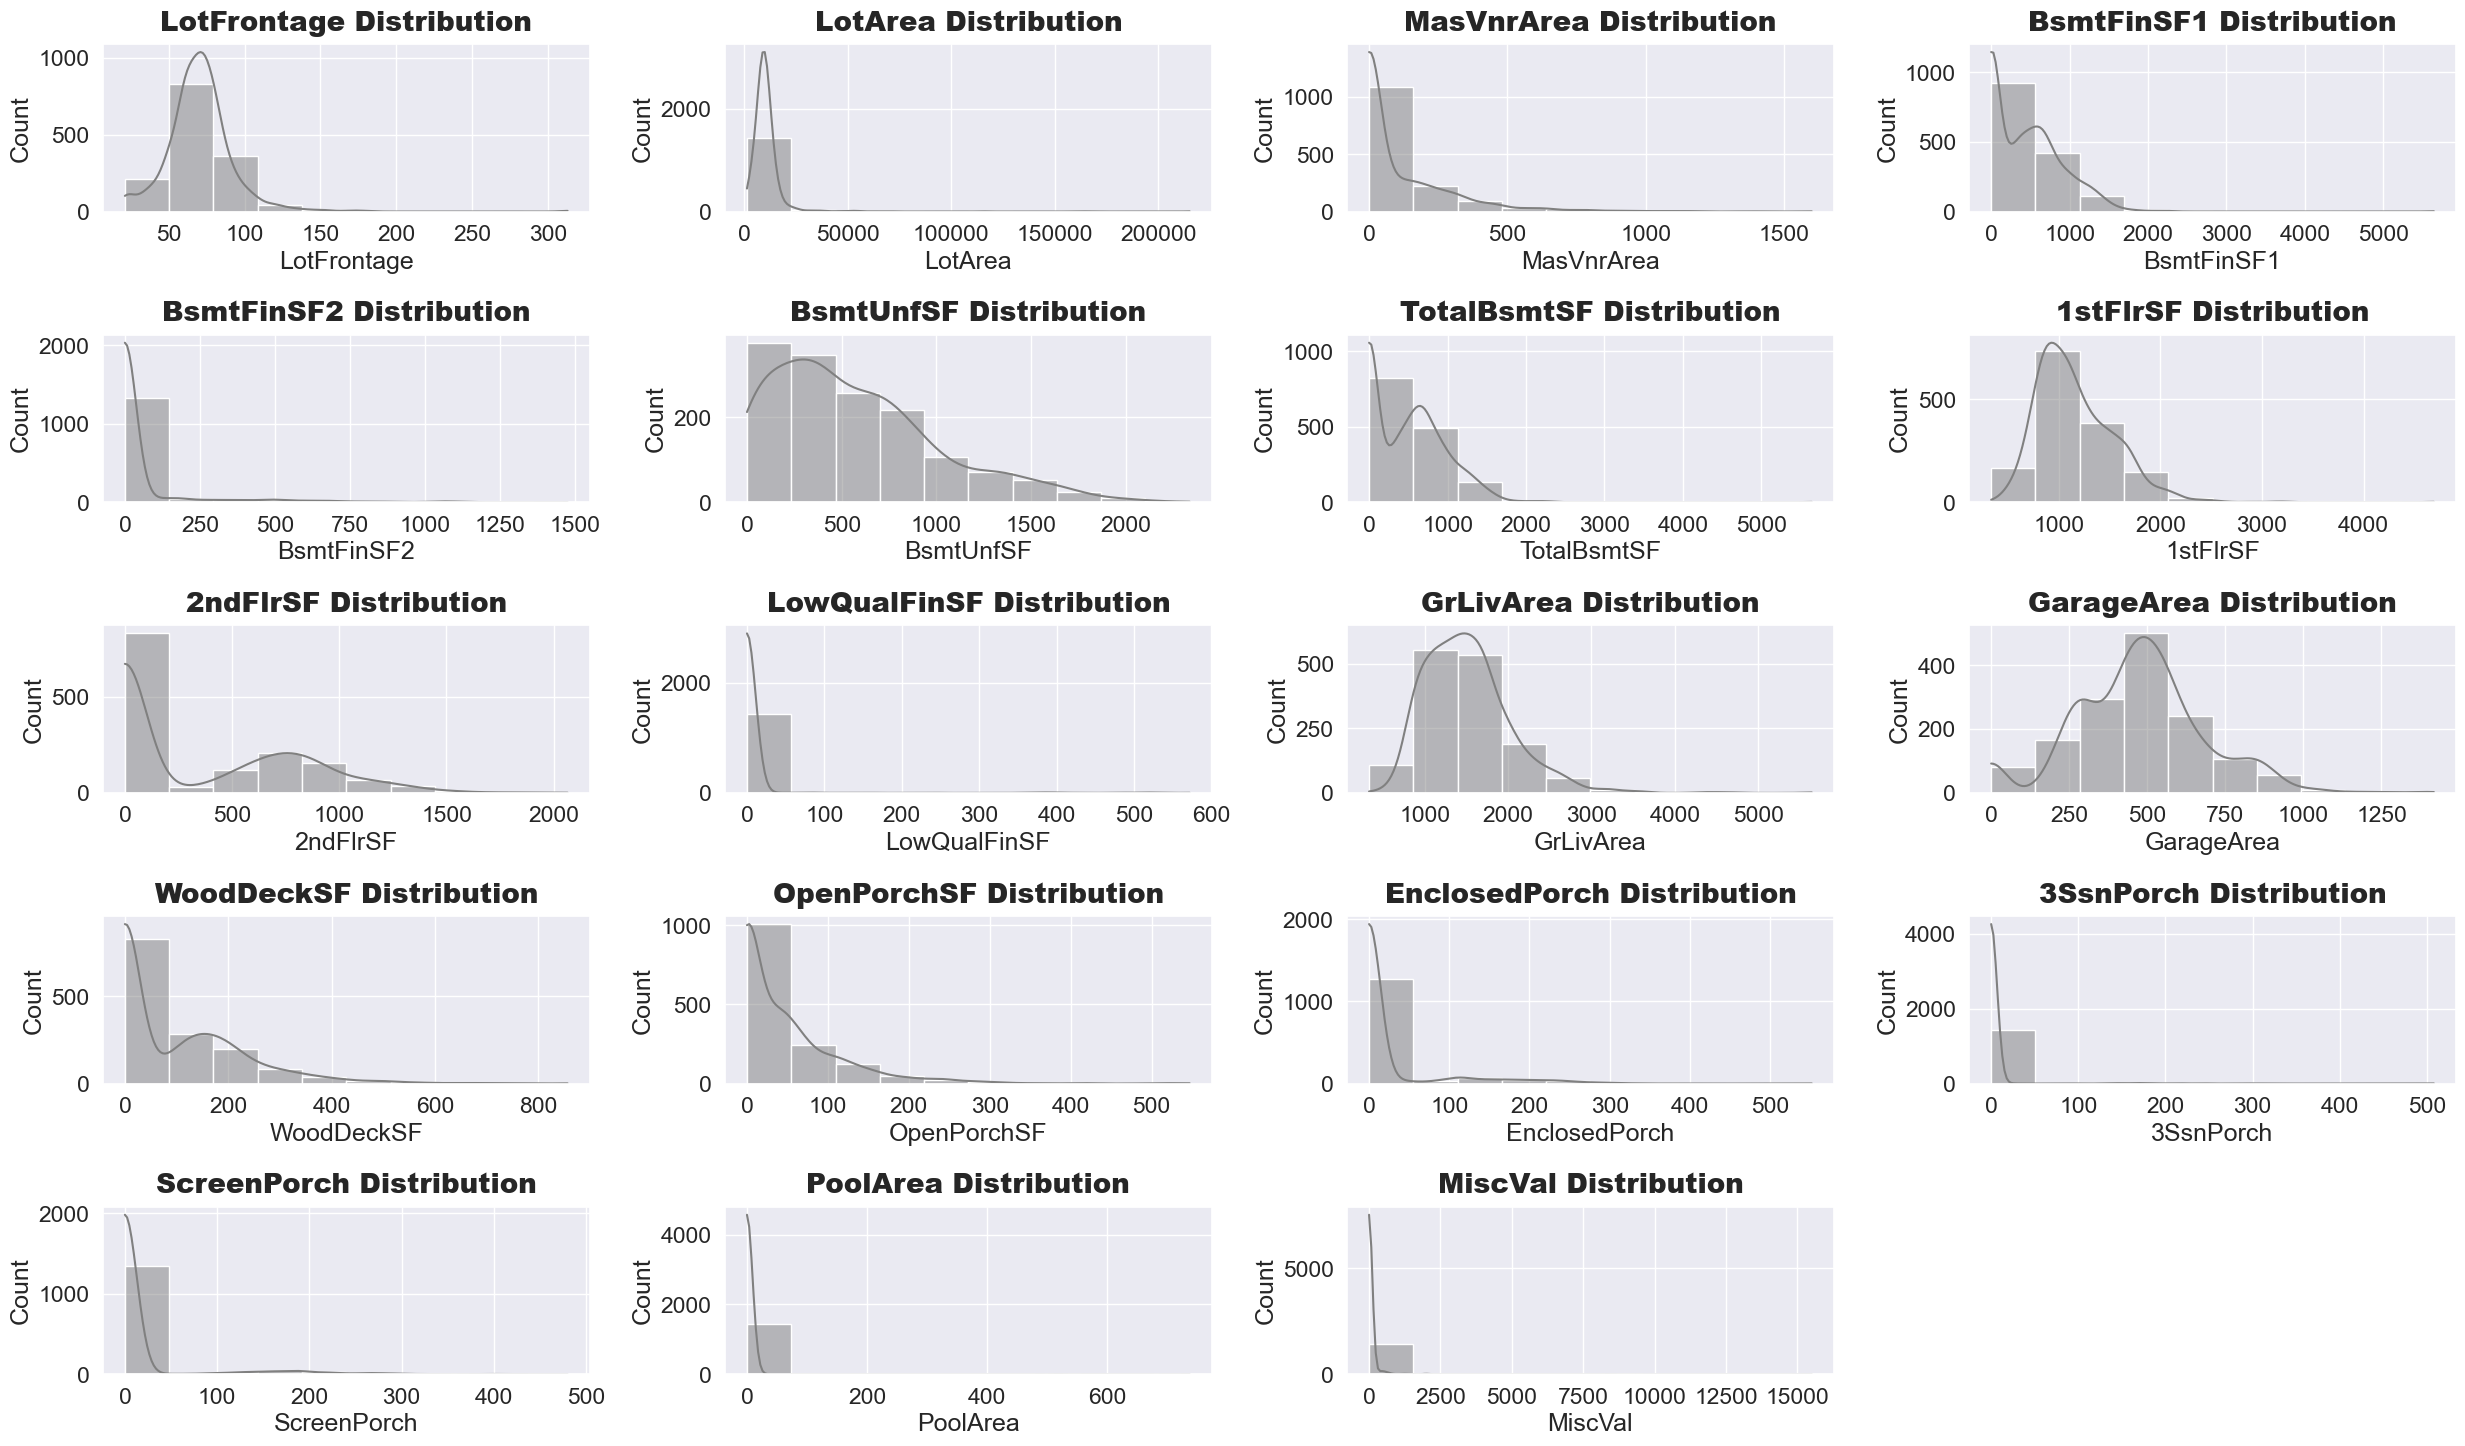

In [162]:
#increasing the figure size
plt.figure(figsize=(25,20))


for idx, val in enumerate(con_cols):
    plt.subplot(7,4,idx+1)

    sns.histplot(
        train_data[val], bins=10, kde=True, color='#808080'
    )
    plt.title(f"{val} Distribution",fontweight="black",size=20,pad=10)
    plt.tight_layout()

Observations:
1. GarageArea is having a kind of Noraml Distribution
2. None of the other features are having a normal distribution and all the features are right-skewed.

4. Visualizing the Skewness of Continuous Features

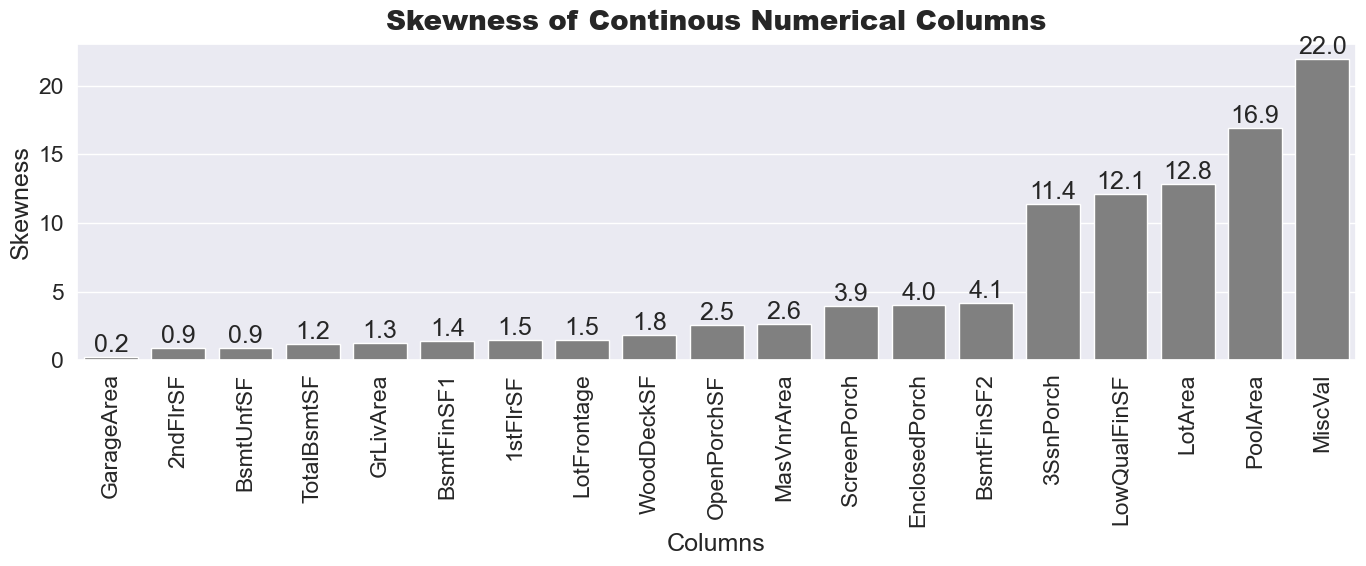

In [172]:
skewness = df[con_cols].skew().sort_values()
plt.figure(figsize=(14,6))

colors= ['#808080']

sns.barplot(
    x=skewness.index,
    y=skewness.values,
    palette=colors
)
for idx, val in enumerate(skewness):
    plt.text(idx, val, f'{val:.1f}', ha='center', va='bottom')
plt.ylabel("Skewness")
plt.xlabel("Columns")
plt.xticks(rotation=90)

plt.title("Skewness of Continous Numerical Columns",fontweight="black",size=20,pad=10)
plt.tight_layout()
plt.show()

Observations:
1. Features like 3SsnPorch,LowQualFinSF,LotArea,PoolArea and MiscVal are having extremly high skewness which can create model-complexity.

#### 5. Visualizing the Correlationof Continous Numerical Features with SalePrice

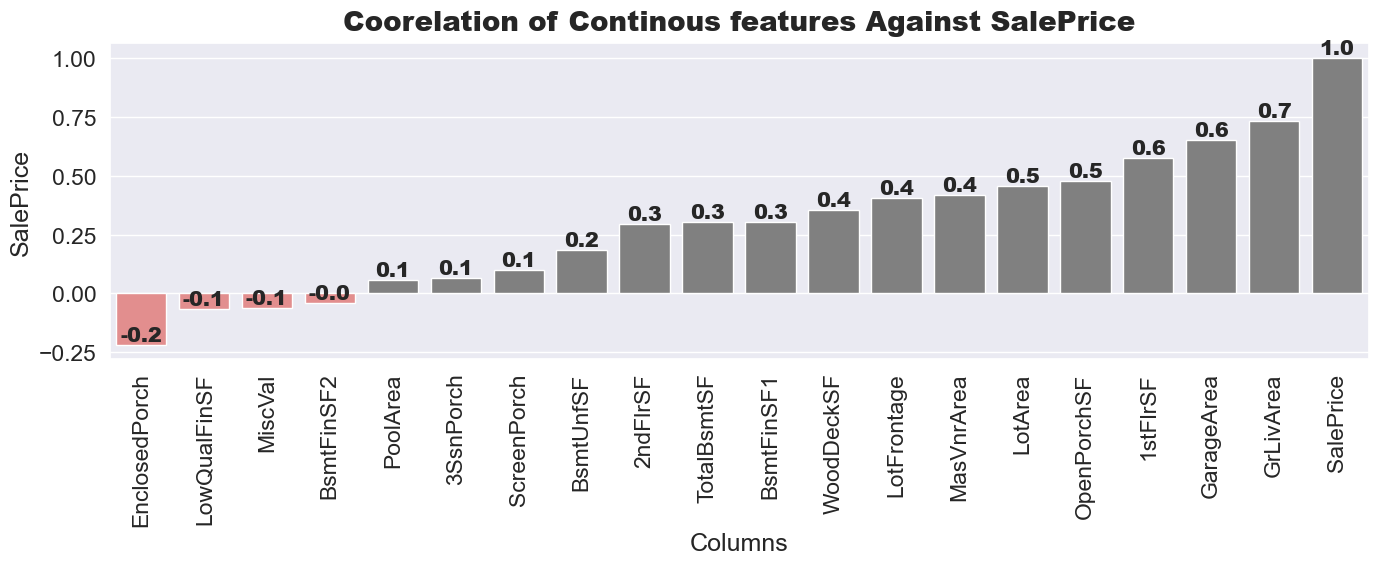

In [176]:
#adding salePrice
con_cols.append("SalePrice")
corr = train_data[con_cols].corr(method='spearman')['SalePrice'].sort_values()
plt.figure(figsize=(14,6))

sns.barplot(
    x=corr.index, y=corr.values, palette=['#808080' if v >0 else 'lightcoral' for v in corr]
)

for idx, val in enumerate(corr):
    plt.text(idx, val, f'{val:.1f}', va='bottom', ha='center', size=15, fontweight='black')

plt.title("Coorelation of Continous features Against SalePrice",fontweight="black",size=20,pad=10)
plt.ylabel("SalePrice")
plt.xlabel("Columns")
plt.xticks(rotation=90)


plt.tight_layout()
plt.show()

1. Features like 1stFlrSF,GrLivArea,and GarageArea are having strong relation with the target variable.
   
2. Features like BsmtUnfSF', 2ndFlrSF, TotalBsmtSF, BsmtFinSF1,WoodDeckSF, LotFrontage, MasVnrArea, LotArea, OpenPorchSF have modearte relation with the target varible.
   
3. Features like PoolArea, 3SsnPorch, ScreenPorch, LowQualFinSF, MiscVal, and EnclosedPorch have very low relation with the target varible, as such they can be dropped if necessary

4. Feature like BsmtFinSf2 has no relation with the target varible as such it will be dropped

   


#### 6. Visualizing Categorical Features against SalePrice(target Variable/ Feature)

In [106]:
cat_cols = train_data.select_dtypes(include="object").columns.tolist()

In [116]:
#creeating a boxplot function

def box_plot(col_list):
    plt.figure(figsize=(22,12))

    for idx, col in enumerate(col_list):
        plt.subplot(2,4, idx +1)
        sns.boxplot(x=col,y='SalePrice',data=train_data, color='#808080')
        plt.title(f'{col} Against SalePrice', fontweight='black', pad=10, size=20)
        plt.xticks(rotation=90)
        plt.tight_layout()
    plt.show()
      

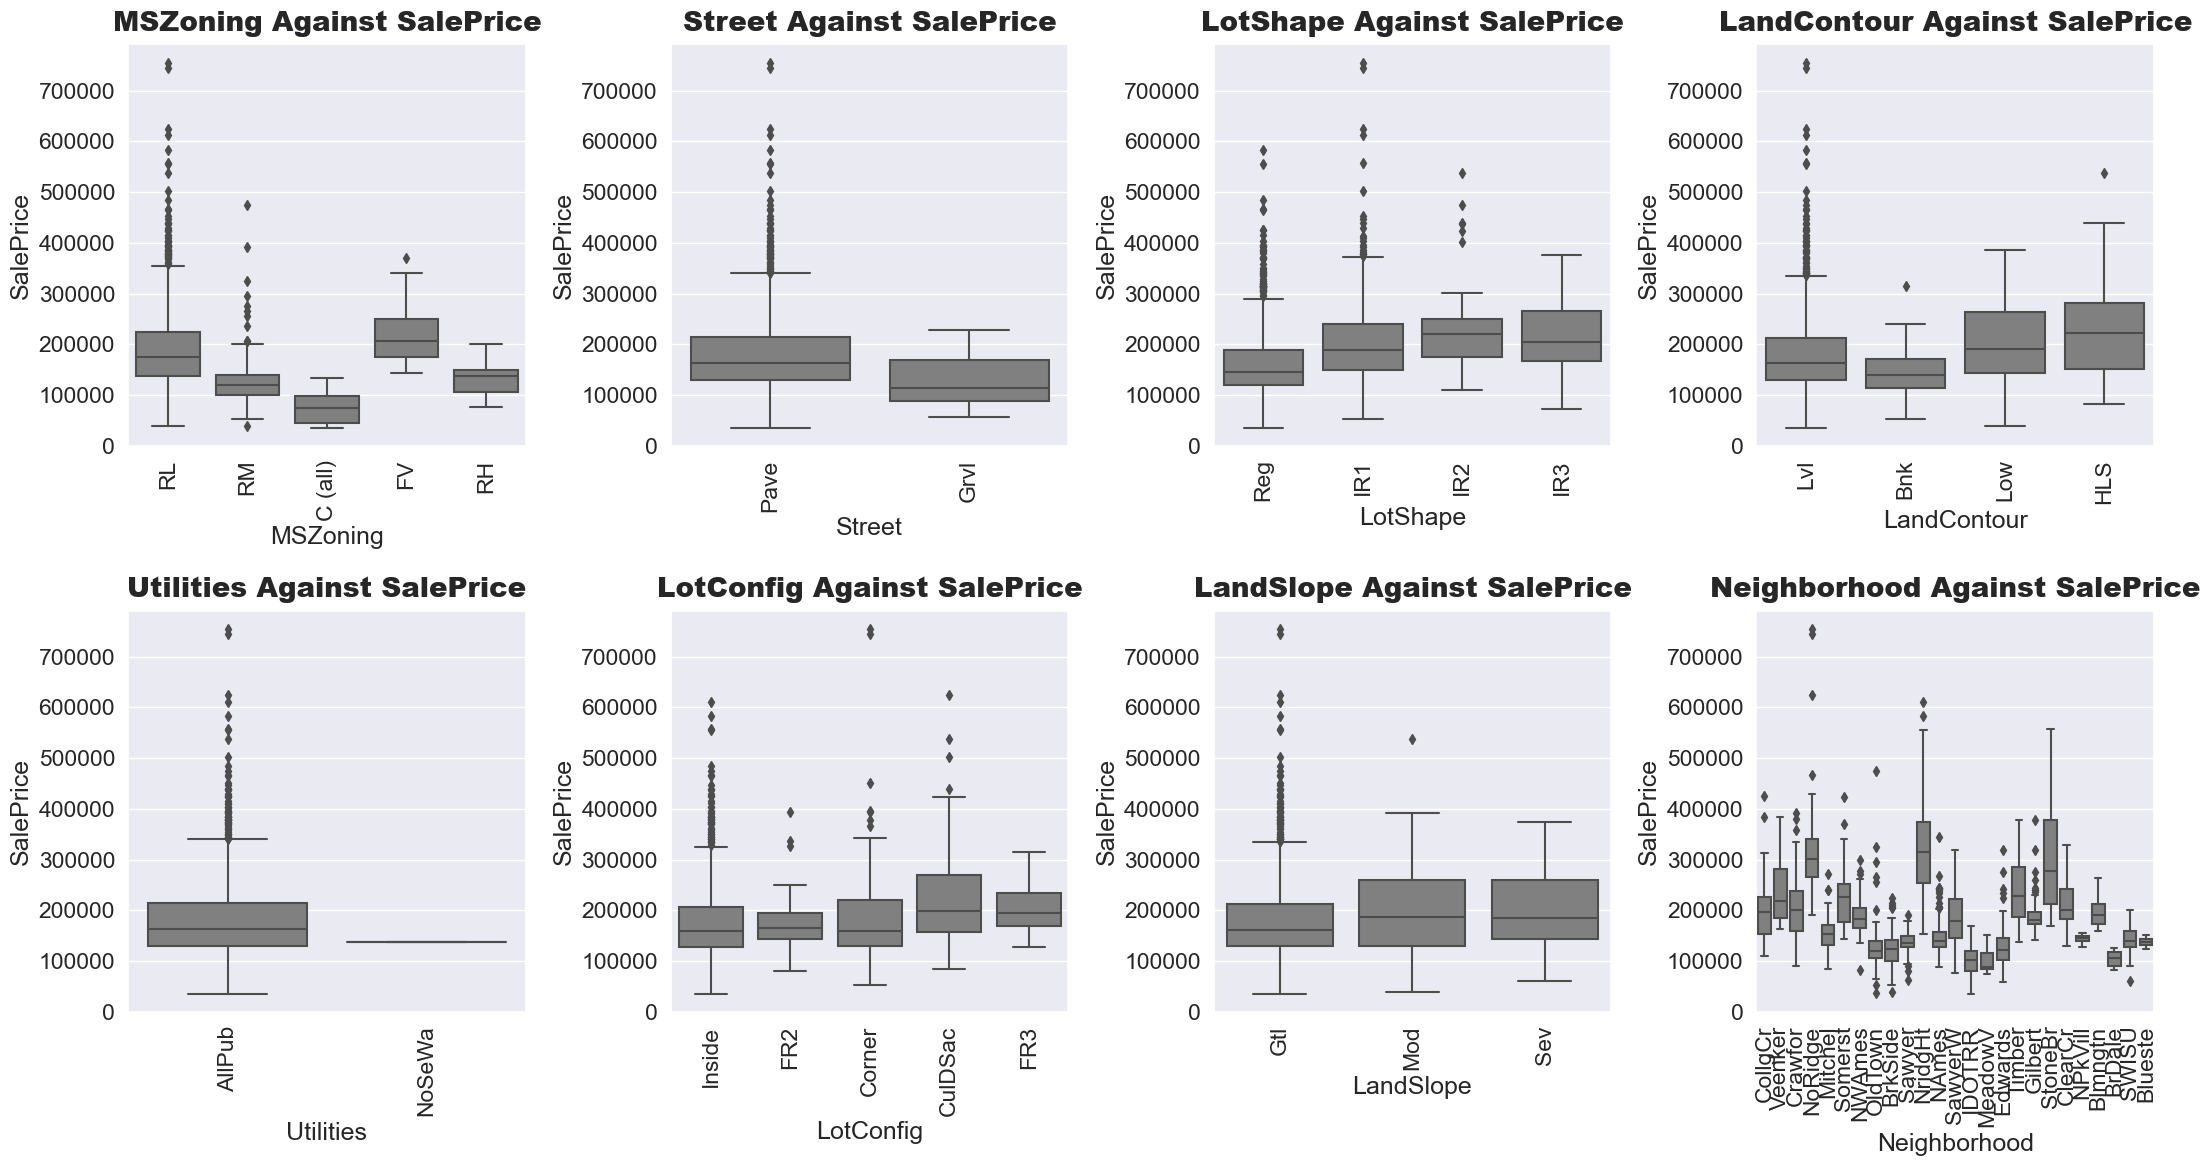

In [117]:
#cat cols 1 to 7
box_plot(col_list=cat_cols[0:8])

Observations:
1. Features like Utilities is having a very high class imbalance while street is have a kind of mid-high class imbalance. So we can just simply drop these features.
2. Neighborhood features has a very high cardinality, so we will perfrom target encoding on this.

In [118]:
#dropping the features with imbalance
train_data.drop(columns=["Utilities","Street"],inplace=True)
test_data.drop(columns=["Utilities","Street"],inplace=True)

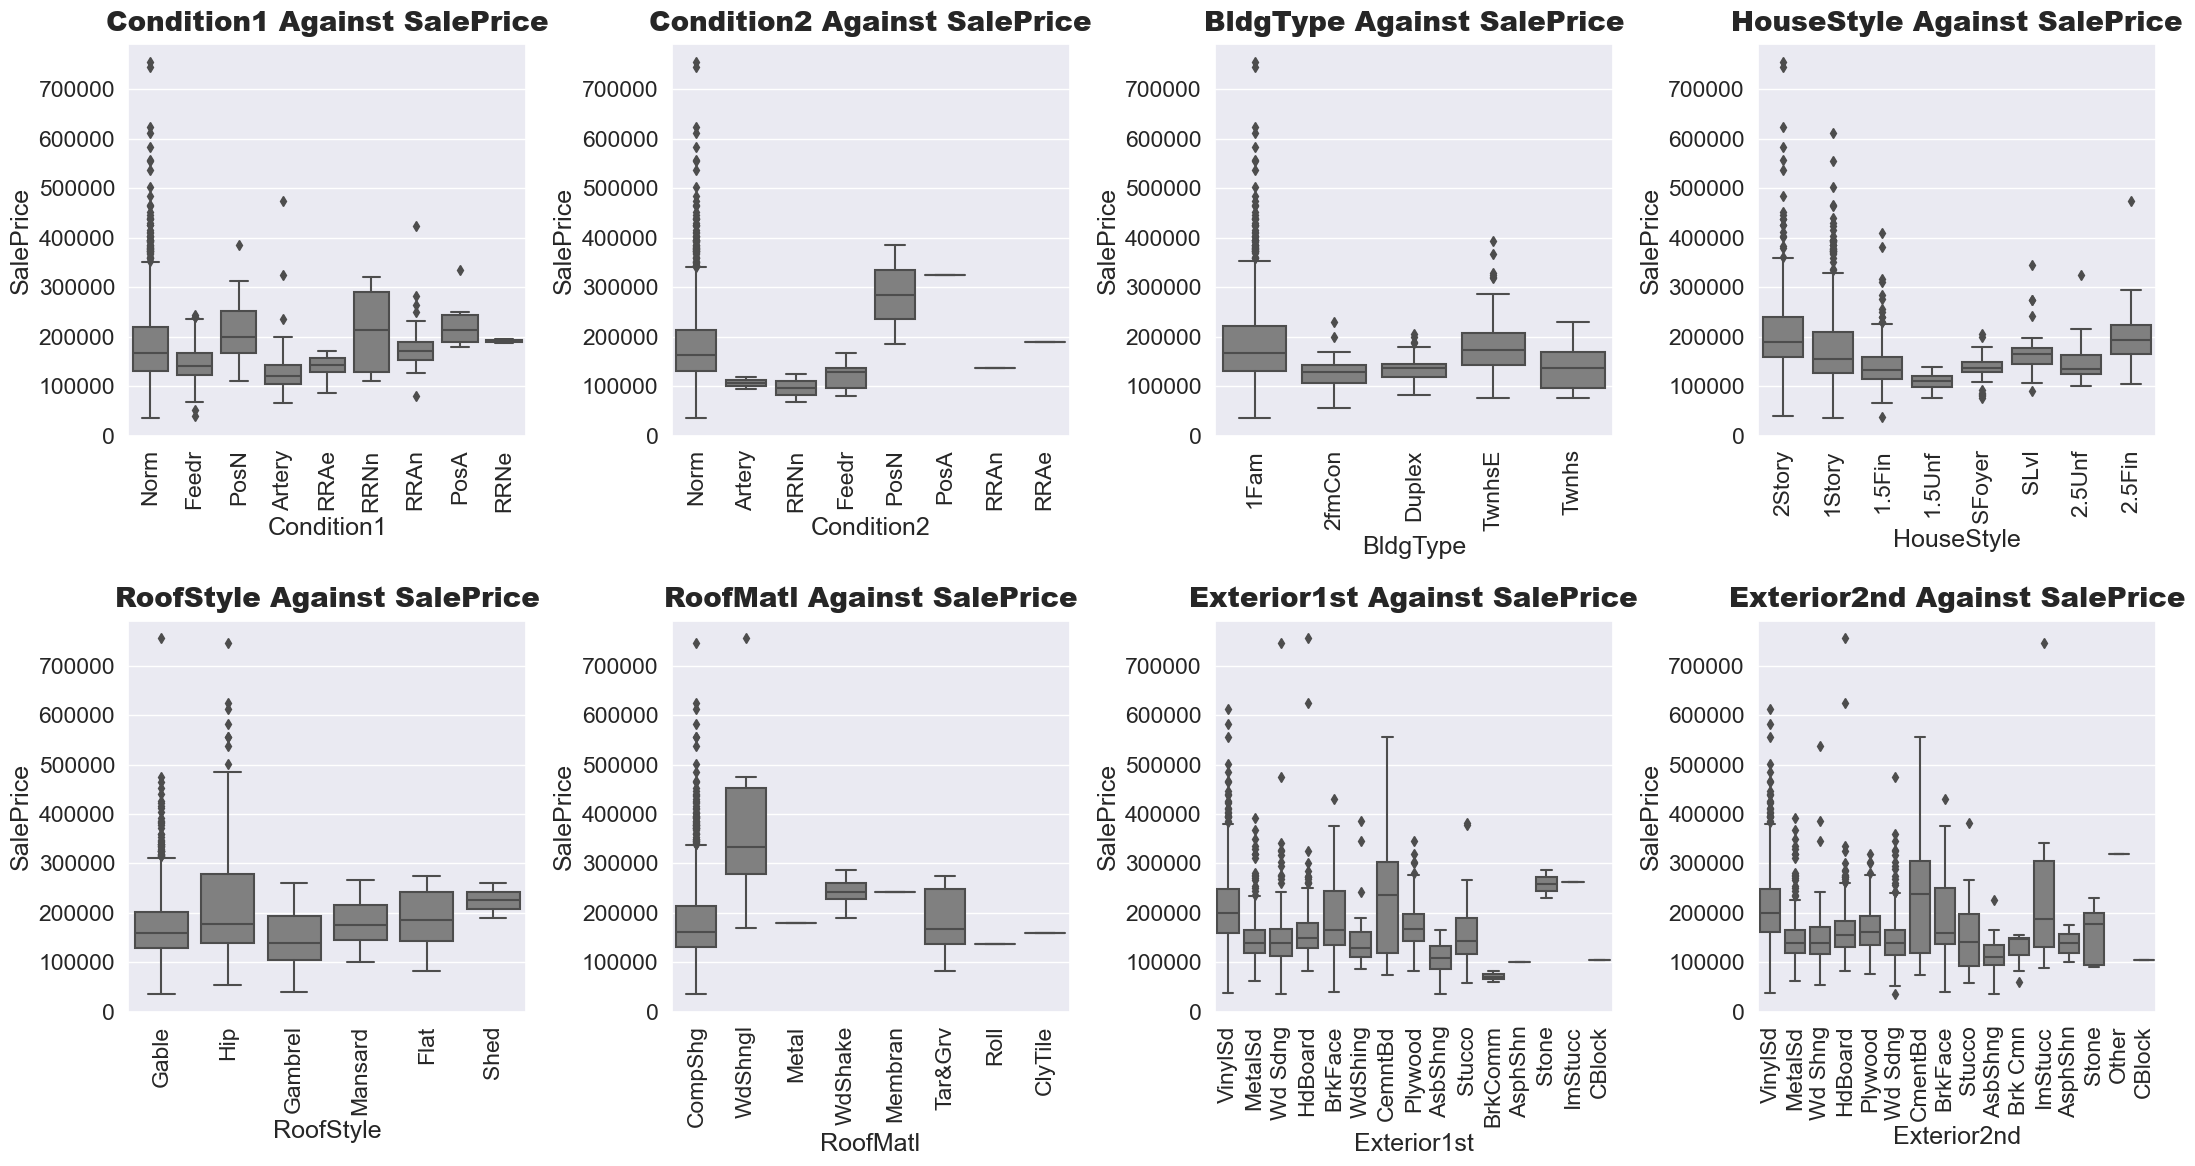

In [120]:
#cat cols 8 to 15
box_plot(col_list=cat_cols[8:16])

1. Features like Condition2 and RoofMatl are having very high class imbalance.
2. We can drop RooftMatl feature and we will fo feature engineering on condition2 to reduce the class-imbalance

In [128]:
#dropping RoofMatl
train_data.drop(columns=["RoofMatl"],inplace=True)
test_data.drop(columns=["RoofMatl"],inplace=True)

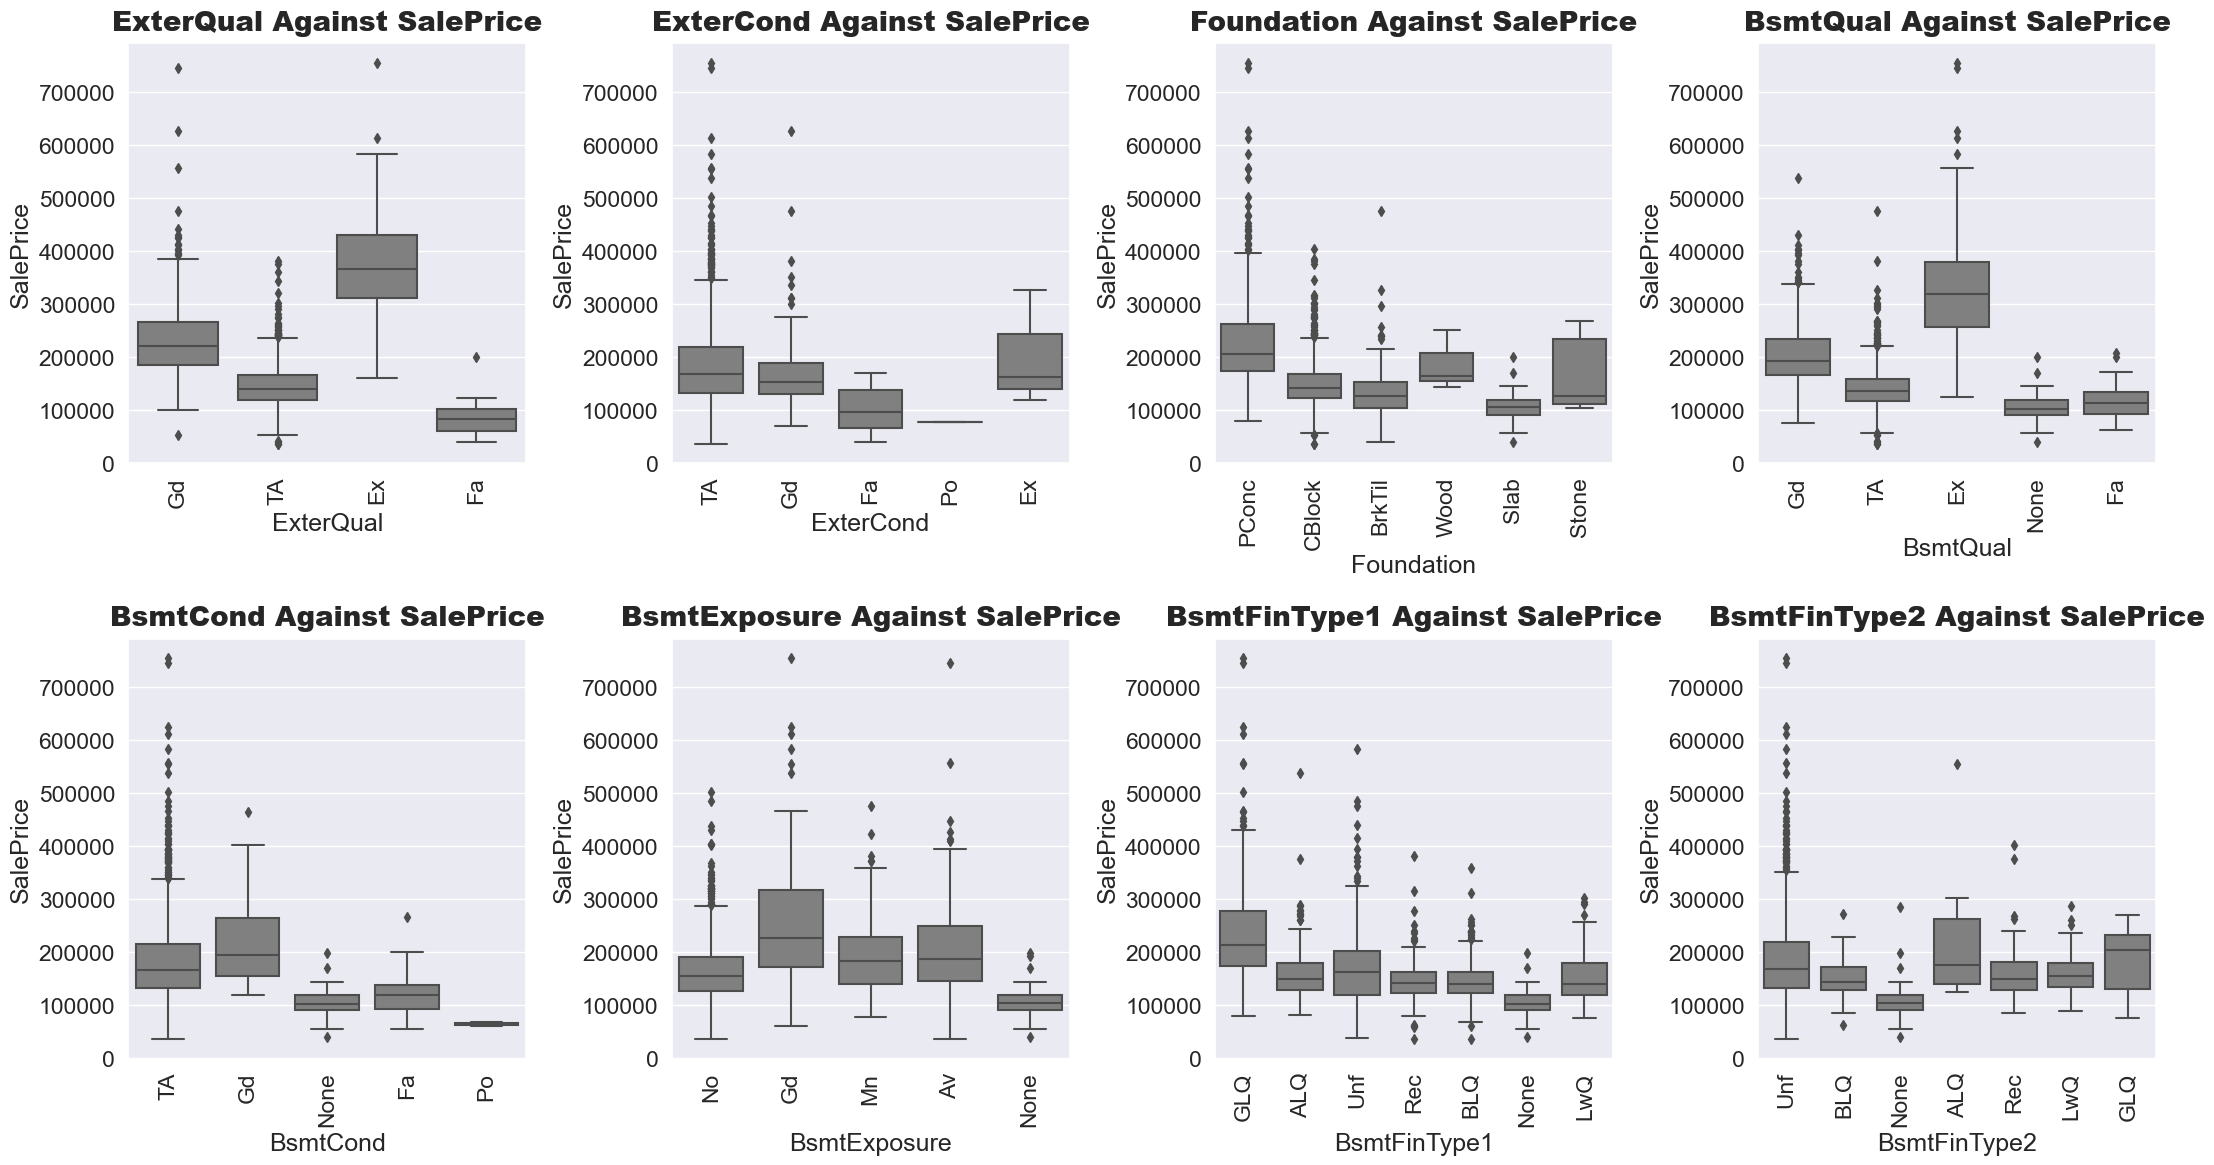

In [126]:
#cat cols 16 to 23
box_plot(cat_cols[16:24])

Observations:
1. All the features in above seems very useful for predicting the price of house.

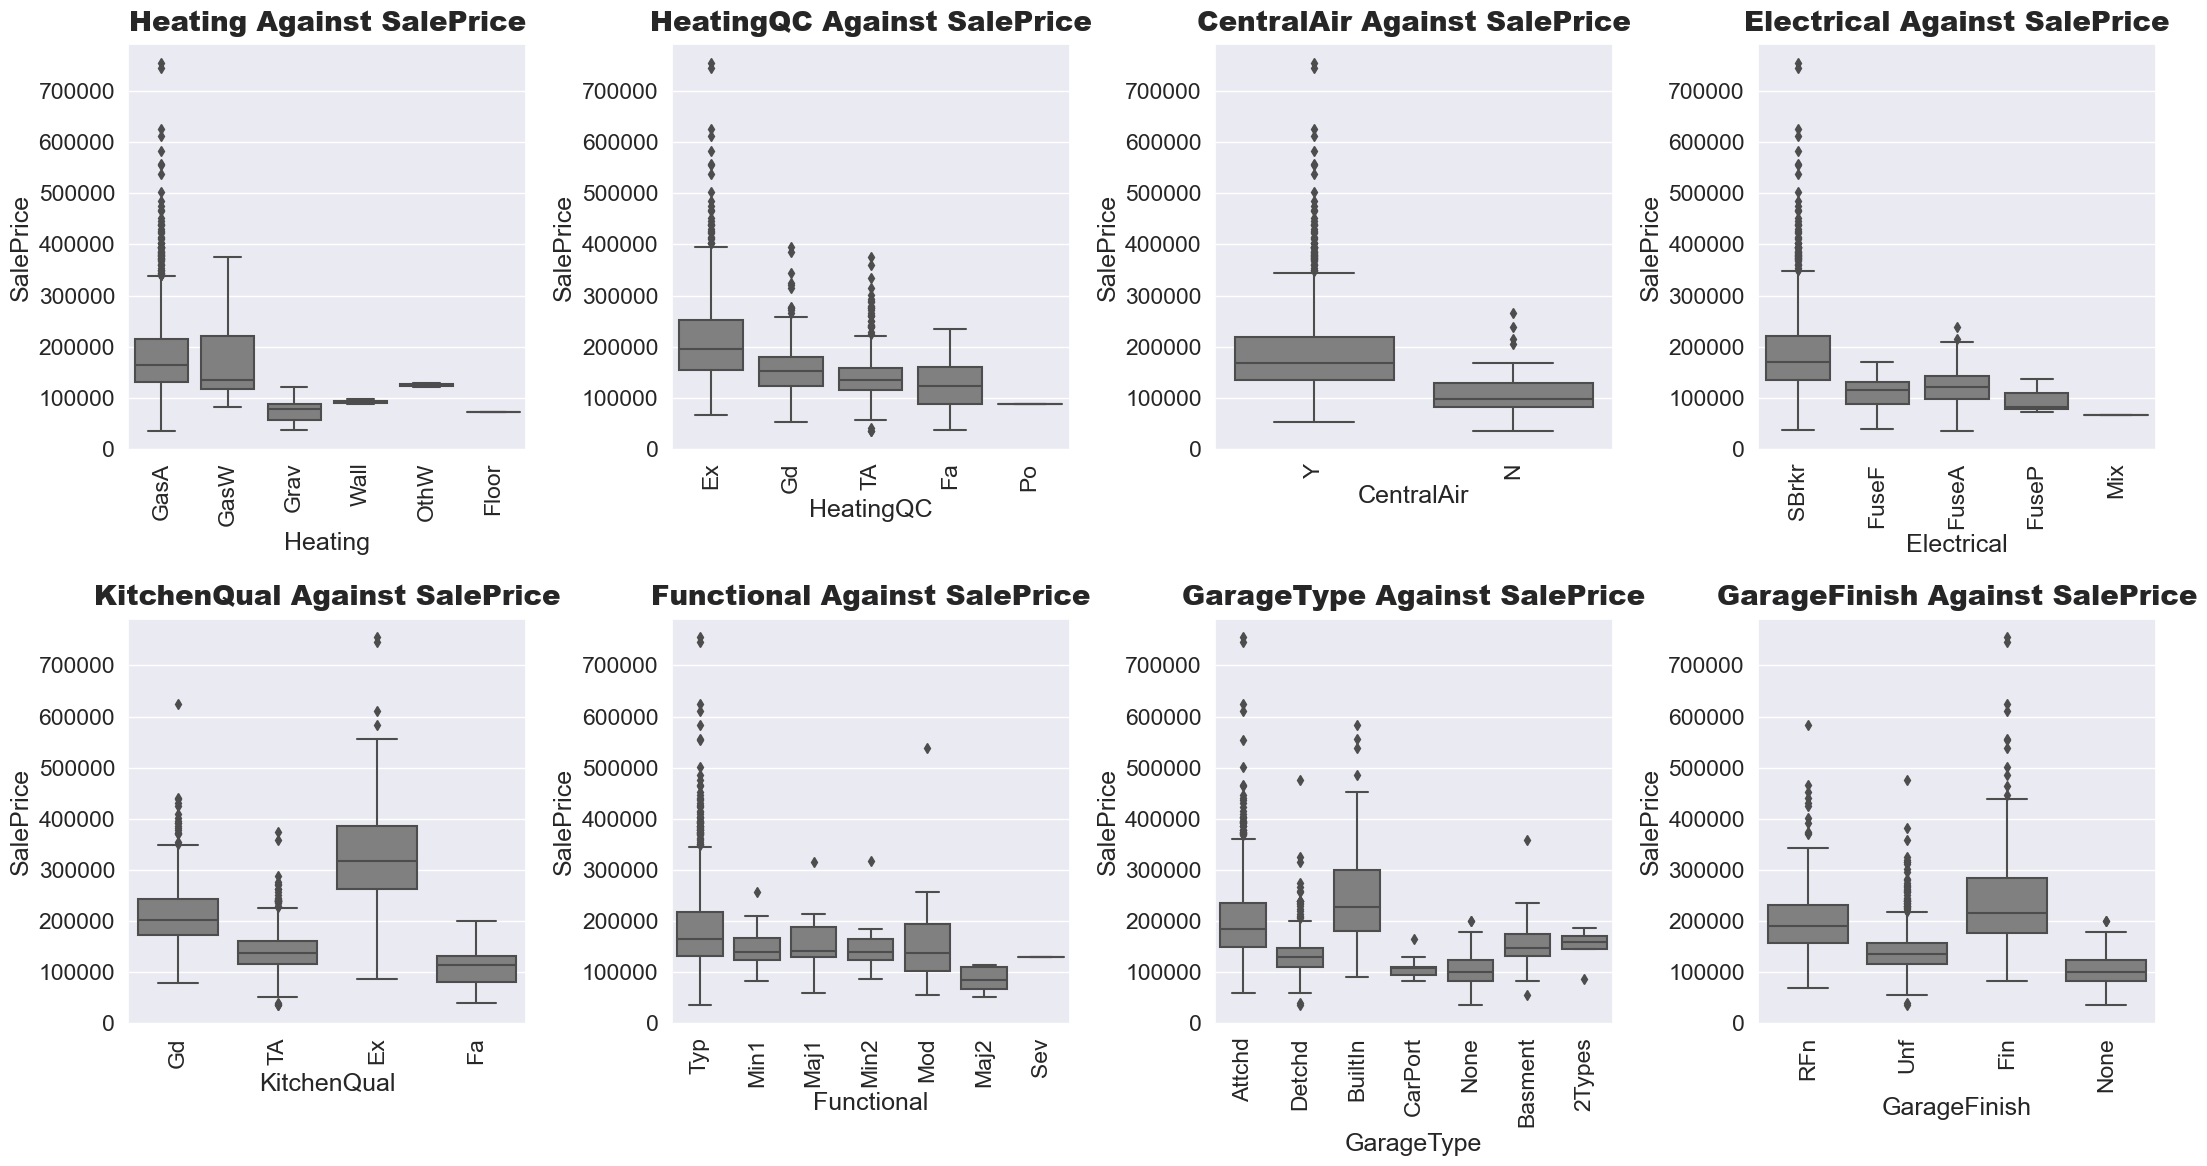

In [129]:
#cat cols 24 to 31
box_plot(cat_cols[24:32])

1. Heating is having a class imbalance. But heating is a important feature for people buying house, we can perform feature engineering to reduce the class-imbalance.
2. Rest all the other features seems useful for house price prediction.

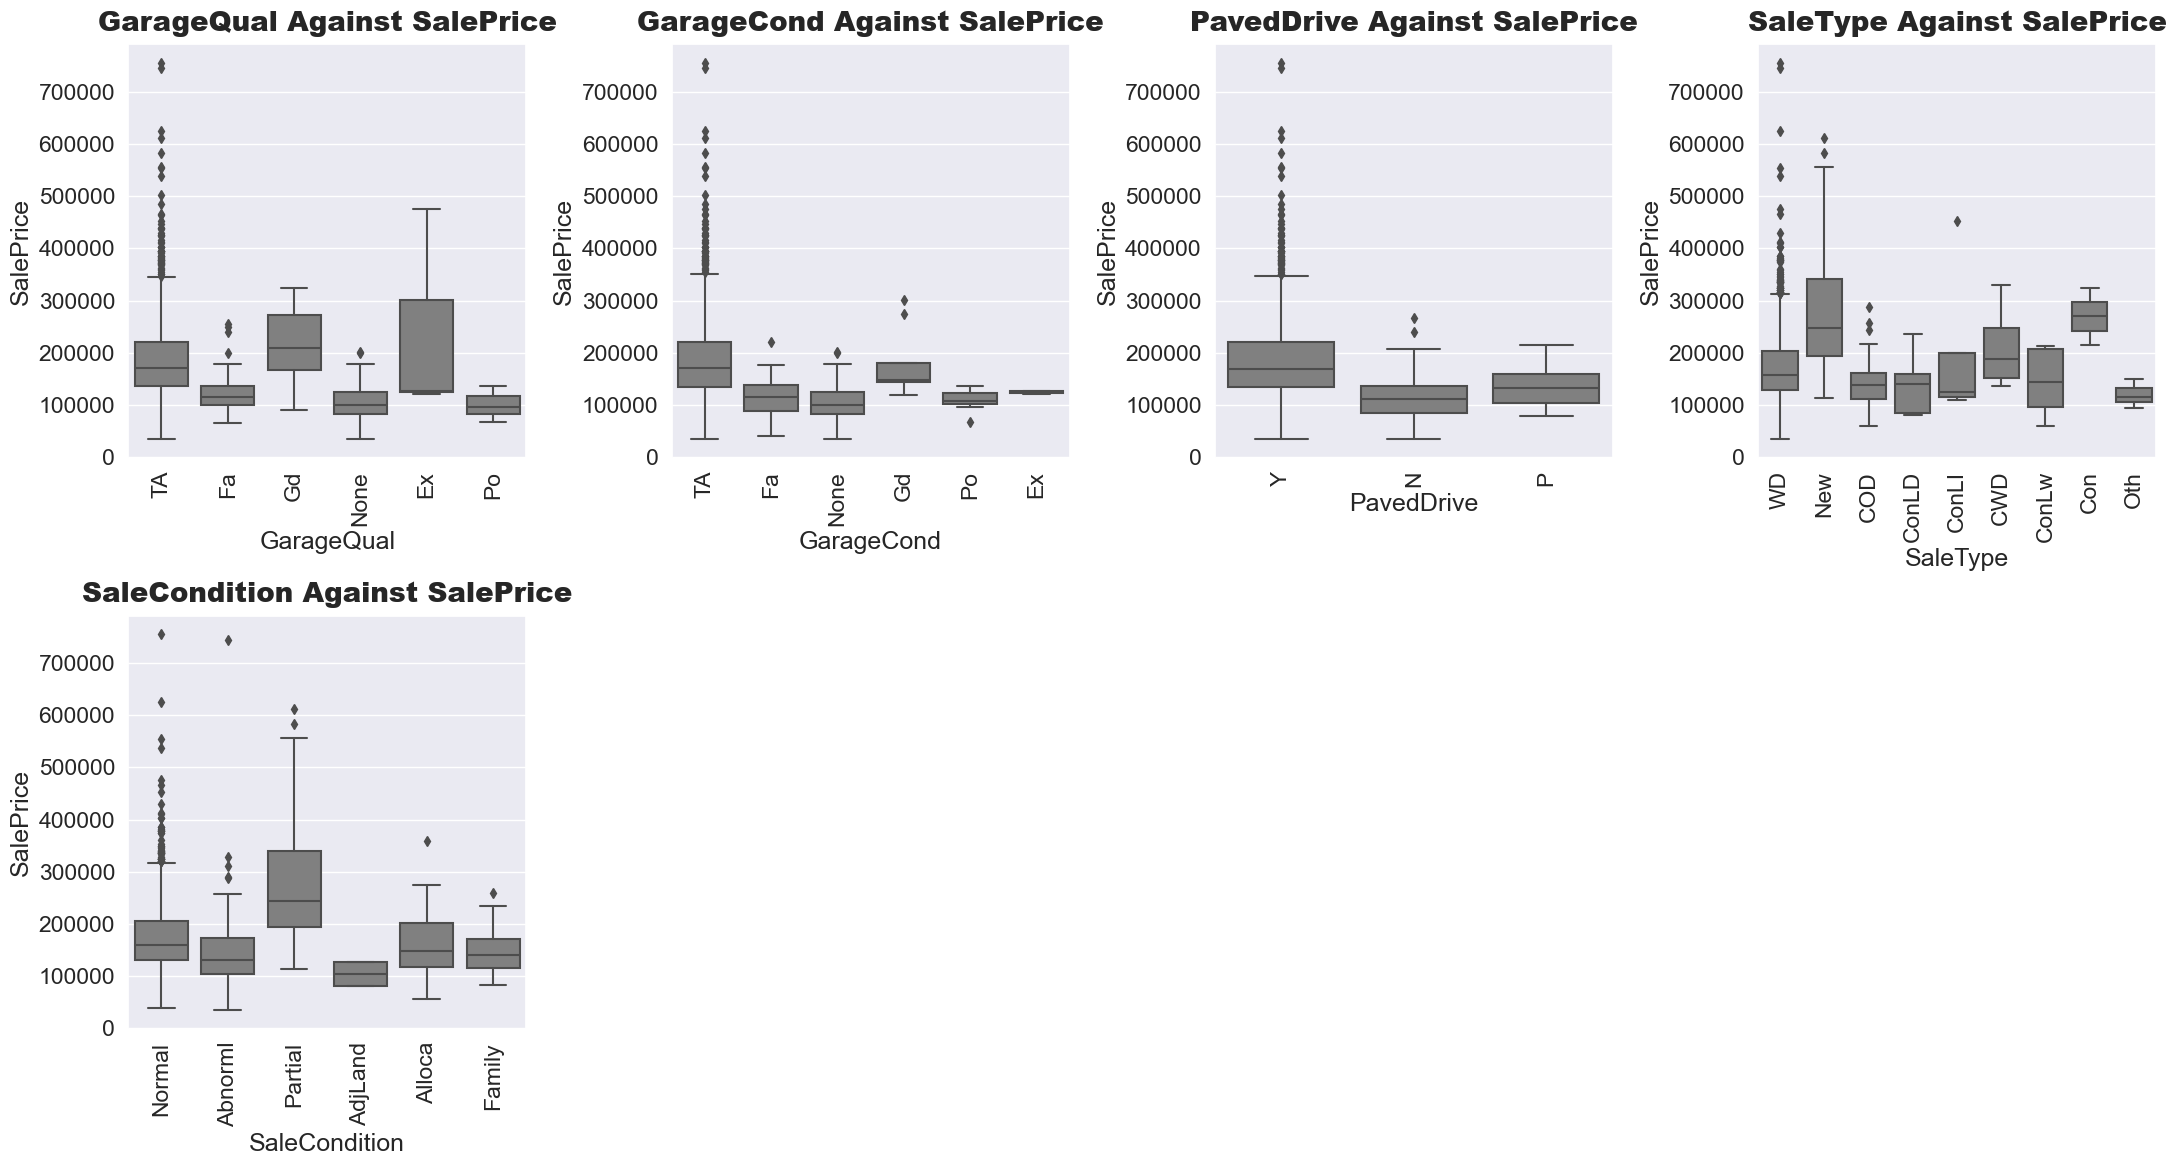

In [130]:
#cat cols 32 till the end
box_plot(cat_cols[32:])

All the features in above visualization seems very useful for predicting the price of house.

In [177]:
dis_cols=["MSSubClass","OverallQual","OverallCond","BsmtFullBath","BsmtHalfBath","FullBath","HalfBath","BedroomAbvGr",
            "KitchenAbvGr","TotRmsAbvGrd","Fireplaces","GarageCars","MoSold", 'YrSold']

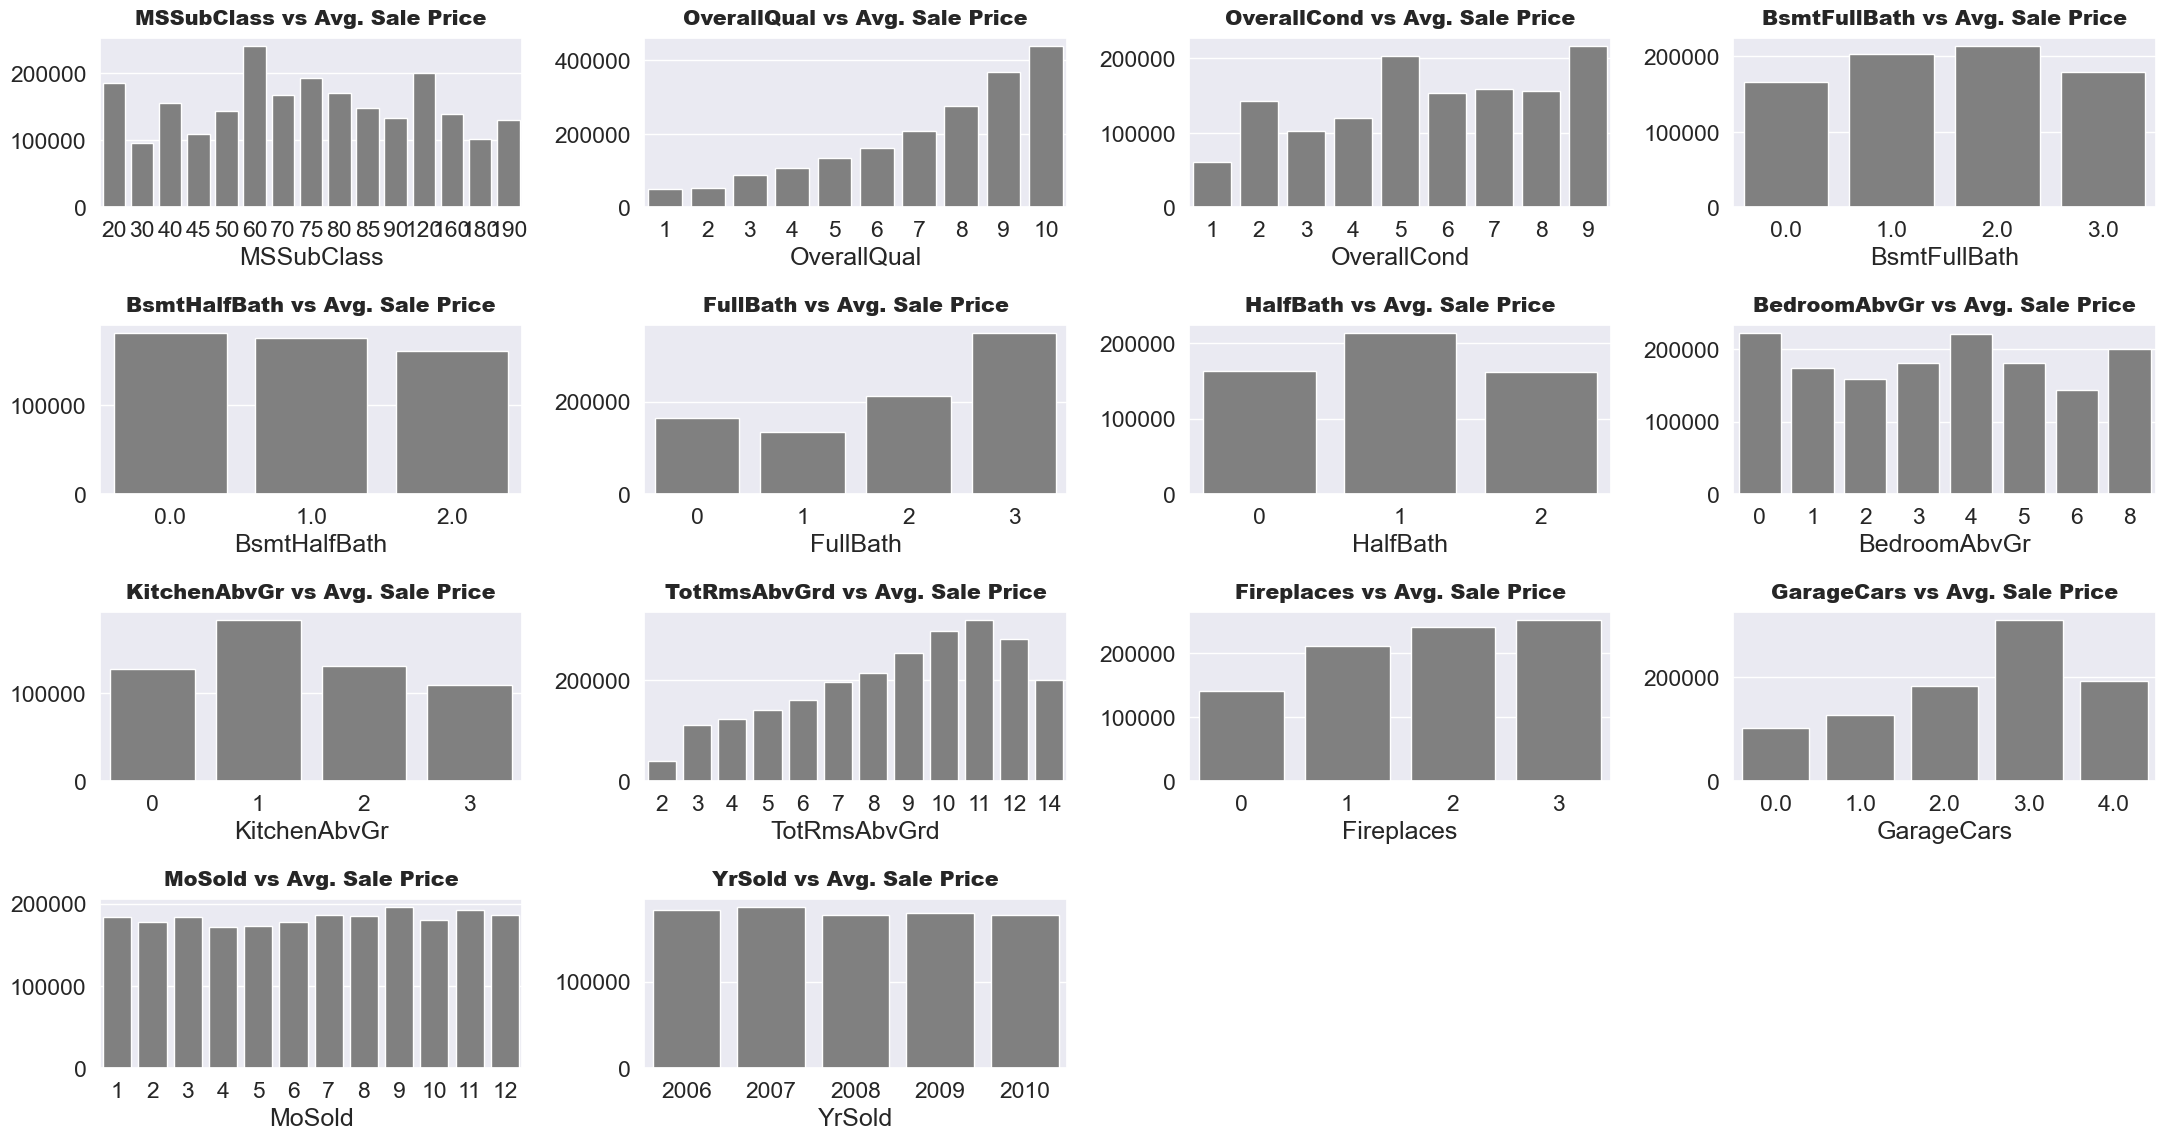

In [187]:
plt.figure(figsize=(22,14))
for idx,col in enumerate(dis_cols):
    data = train_data.groupby(col)["SalePrice"].mean()
    plt.subplot(5,4,idx+1)
    sns.barplot(x=data.index, y=data.values, color='#808080')
    plt.title(f"{col} vs Avg. Sale Price",fontweight="black",size=15,pad=10)
    plt.tight_layout()

Observations:

1. OverallQual,FullBath,TotRmsAbvGrd, FirePlaces and GarageCars are having strong positive relation with the SalePrice.

2. KitchenAbvGr is having a negative correlation with SalePrice.



#### <b> Feature Engineering </b>

Creating 

1. Renovation Status, 
2. AgeAtSale, 

With
1. YearBuilt: It shows the Original construction date*
2. YrSold: It shows the original Year Sold (YYYY)
3. YearRemodAdd: It shows Remodel date (same as construction date if no remodeling or additions).

In [195]:
train_data['Renovation_Status'] = (train_data['YearBuilt'] != train_data['YearRemodAdd']).astype(int)
test_data['Renovation_Status'] = (test_data['YearBuilt'] != test_data['YearRemodAdd']).astype(int)

In [196]:
train_data['AgeAtSale']= train_data['YearBuilt'] - train_data['YrSold']
test_data['AgeAtSale']= test_data['YearBuilt'] - test_data['YrSold']

In [205]:
#dropping unwanted features
train_data.drop(columns=["YearBuilt","YrSold","YearRemodAdd"],inplace=True)
test_data.drop(columns=["YearBuilt","YrSold","YearRemodAdd"],inplace=True)

Visualizing the New Features Created

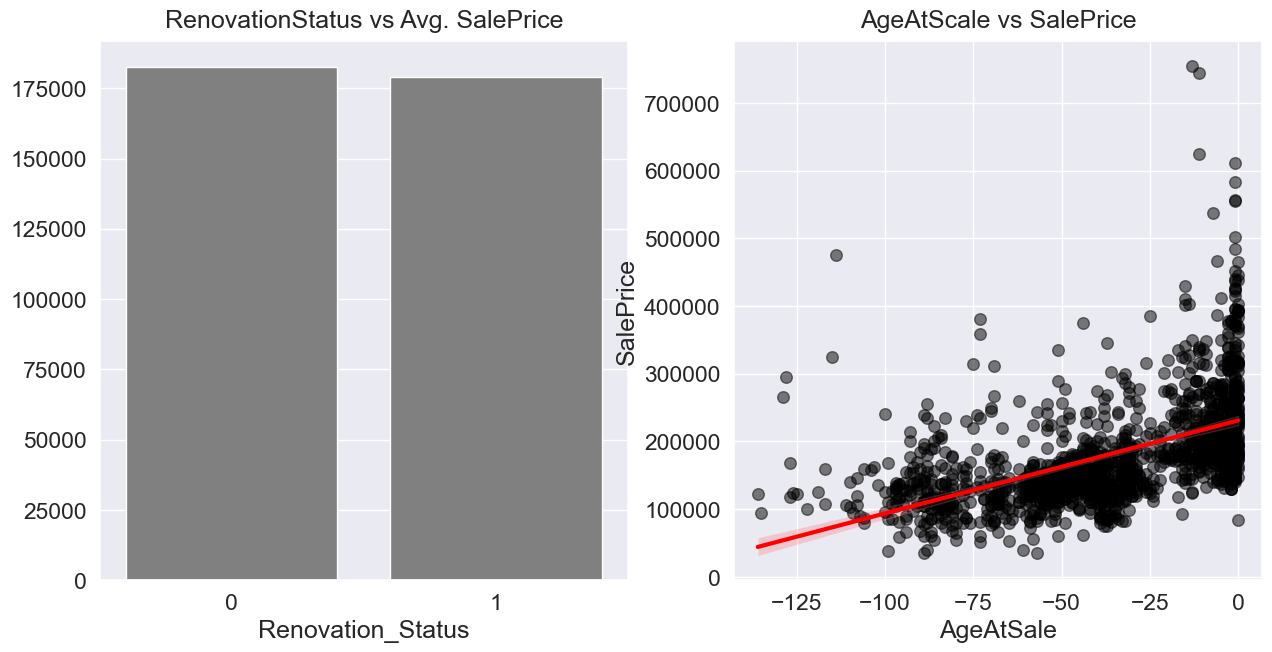

In [242]:
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
data=train_data.groupby("Renovation_Status")["SalePrice"].mean()
sns.barplot(x=data.index,y=data.values , color='#808080')
plt.title("RenovationStatus vs Avg. SalePrice",pad=10)


plt.subplot(1,2,2)
sns.regplot(x=train_data["AgeAtSale"],y=train_data["SalePrice"],color="black", scatter_kws={'s': 70, 'alpha': 0.5}, 
                line_kws={'color': 'red', 'lw': 3})
plt.title("AgeAtScale vs SalePrice",pad=10)


plt.show()

1. The SalePrice for both the RenovationStatus cateegory is approxiamately same.
2. There is a negative correlation between AgeAtScale & SalePrice.

2. Total Bathrooms

In [236]:
train_data["Total_Bathrooms"] = (train_data["FullBath"] + (0.5 * train_data["HalfBath"]) + 
                               train_data["BsmtFullBath"] + (0.5 * train_data["BsmtHalfBath"]))
test_data["Total_Bathrooms"] = (test_data["FullBath"] + (0.5 * test_data["HalfBath"]) + 
                               test_data["BsmtFullBath"] + (0.5 * test_data["BsmtHalfBath"]))

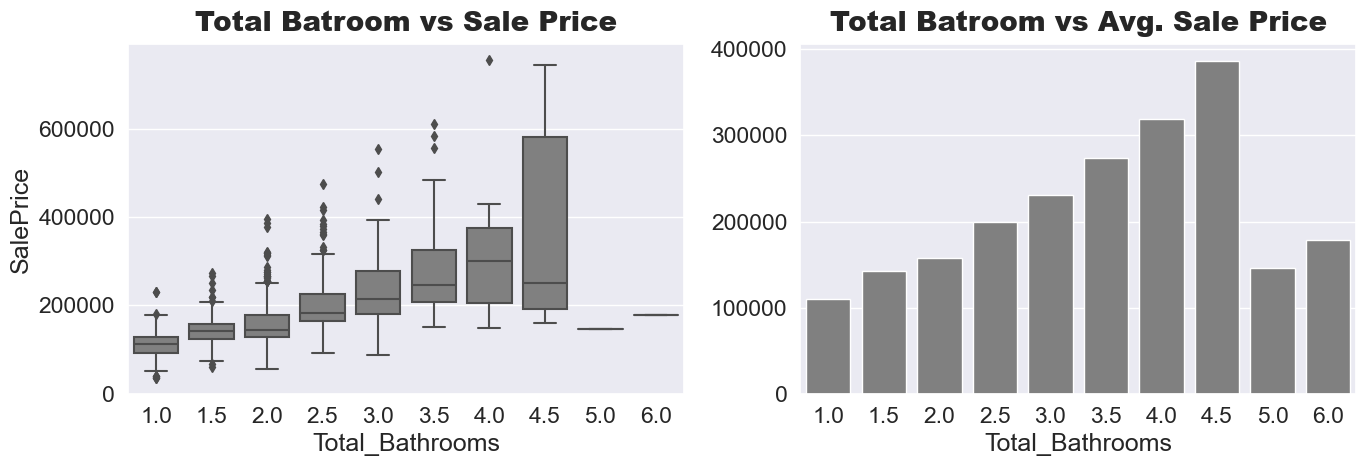

In [245]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
sns.boxplot(x=train_data["Total_Bathrooms"], y=train_data["SalePrice"], color="#808080")
plt.title("Total Batroom vs Sale Price",fontweight="black",size=20,pad=10)

plt.subplot(1,2,2)
avg = train_data.groupby("Total_Bathrooms")["SalePrice"].mean()
sns.barplot(x= avg.index,y=avg.values,color="#808080")
plt.title("Total Batroom vs Avg. Sale Price",fontweight="black",size=20,pad=10)
plt.tight_layout()
plt.show()

In [246]:
# plt.figure(figsize=(25,25))

# sns.heatmap(
#     train_data.corr(numeric_only=True),fmt='.1f', annot=True
# )

### I Will continue tomorrow